In [ ]:
from google.colab import files
files.upload()   # Aquí sube tu kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jorgeeduardoqs","key":"e6a4af33633563bccc0551179373daa2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d m41k12/imagenes-lima-metropolitana
!unzip imagenes-lima-metropolitana.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/m41k12/imagenes-lima-metropolitana
License(s): unknown
imagenes-lima-metropolitana.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imagenes-lima-metropolitana.zip
replace data/X_features.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/X_features.npy     
replace data/X_features_g.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/X_features_g.npy   
replace data/X_features_l.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/X_features_l.npy   
replace data/final_images/final_images/Alto/Alto_La Molina_01_20251118_210128_481169.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

sns.set(style="whitegrid")


## Ruteo de Carpetas

In [ ]:
root_path = "data/final_images/final_images"

# Filtrar solo carpetas válidas
clases = [c for c in os.listdir(root_path)
          if os.path.isdir(os.path.join(root_path, c))
          and not c.startswith('.')
          and c != '.ipynb_checkpoints']

clases



['Medio', 'Alto', 'Bajo']

## Conteo de Imágenes por Categoría

## Primera visualización


# 1. Introducción al Análisis Exploratorio de Datos (EDA)

En este proyecto trabajamos con un conjunto de imágenes obtenidas desde **Google Street View** de distintos distritos de **Lima Metropolitana**, clasificadas en tres categorías socioeconómicas principales:

- **Bajo**  
- **Medio**  
- **Alto**

El objetivo del proyecto es desarrollar un modelo de **Machine Learning / Computer Vision** capaz de **predecir el estrato socioeconómico** de una nueva imagen urbana.  
Para ello, es indispensable realizar un **Análisis Exploratorio de Datos (EDA)** que permita comprender la naturaleza del dataset y validar que el problema es abordable desde una perspectiva visual.


## 1.1 Objetivo del EDA

El propósito del EDA es evaluar si las imágenes contienen **señales visuales suficientes y consistentes** que permitan distinguir entre los estratos Bajo, Medio y Alto.  
Además, el EDA busca garantizar la **calidad, coherencia y usabilidad** del dataset antes de comenzar el modelado.

En particular, nos enfocaremos en:

- Analizar la **distribución del número de imágenes por clase** y detectar desbalances.  
- Revisar la **calidad visual** de las imágenes (resolución, formato, presencia de archivos corruptos).  
- Identificar **diferencias visuales urbanas** entre estratos (vegetación, densidad, estructura vial, uniformidad de fachadas, iluminación).  
- Detectar posibles **outliers o ruido** (imágenes borrosas, duplicadas o mal etiquetadas).  
- Obtener **insights** para justificar decisiones posteriores como:  
  - normalización  
  - augmentations  
  - manejo de desbalance  
  - elección de modelos





# 2. Exploración de la Estructura del Dataset

En esta sección revisamos cómo están organizadas las imágenes dentro del dataset, verificamos la cantidad de muestras por clase y buscamos posibles inconsistencias (archivos corruptos, resoluciones irregulares o carpetas inválidas).  
Garantizar la calidad del dataset es esencial para entrenar correctamente modelos de visión por computadora.


## 2.1 Definir rutas y listar clases

Primero definimos la ruta principal donde se encuentran las imágenes y listamos las carpetas correspondientes a las clases **Bajo**, **Medio** y **Alto**, filtrando cualquier directorio que no sea una clase válida.


In [ ]:
root_path = "data/final_images/final_images"

clases = [
    c for c in os.listdir(root_path)
    if os.path.isdir(os.path.join(root_path, c))
    and not c.startswith(".")
    and c != ".ipynb_checkpoints"
]

clases

['Medio', 'Alto', 'Bajo']

## 2.2 Conteo de imágenes por clase

Verificamos cuántas imágenes conforman cada categoría.
Esto permite detectar desbalance de clases, que es importante para el modelado posterior.

In [ ]:
conteo = {
    c: len([
        x for x in os.listdir(os.path.join(root_path, c))
        if x.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    for c in clases
}

import pandas as pd
df_conteo = pd.DataFrame.from_dict(conteo, orient="index", columns=["num_imagenes"])
df_conteo


num_imagenes
Medio          4011
Alto           5575
Bajo           5511

## 2.3 Visualización: distribución del dataset por clase

Graficamos el conteo para observar si existe desbalance significativo entre las clases.

/tmp/ipython-input-2675408121.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_conteo.index, y=df_conteo["num_imagenes"], palette="viridis")


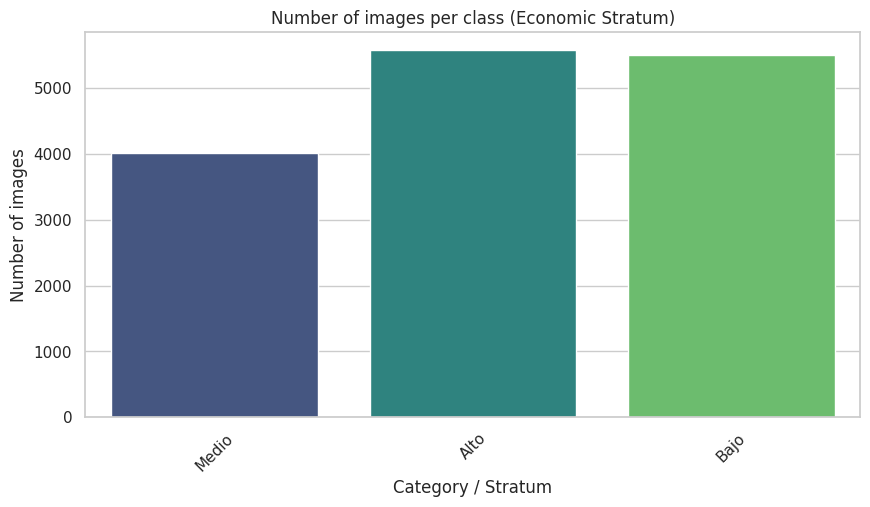

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=df_conteo.index, y=df_conteo["num_imagenes"], palette="viridis")
plt.title("Number of images per class (Economic Stratum)")
plt.xlabel("Category / Stratum")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.show()


Las clases tienen diferentes cantidades de imágenes lo cual nos indica que podríamos usar técnicas de sampleo.

## 2.4 Revisión de archivos inválidos o corruptos

Validamos que todas las imágenes puedan abrirse correctamente.
Esto permite detectar imágenes corruptas o incompletas.

In [ ]:
imagenes_invalidas = []

for c in clases:
    folder = os.path.join(root_path, c)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            try:
                Image.open(img_path).verify()
            except Exception:
                imagenes_invalidas.append(img_path)

imagenes_invalidas[:10], len(imagenes_invalidas)


([], 0)

No hay imágenes invalidas

## 2.5 Auditoría de resolución de imágenes

Revisamos las dimensiones de las imágenes para asegurarnos de que todas tengan el mismo tamaño, lo que simplifica el preprocesamiento.

In [ ]:
dimensiones = []

for c in clases:
    folder = os.path.join(root_path, c)
    for img_name in os.listdir(folder):
        if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            try:
                img = Image.open(os.path.join(folder, img_name))
                dimensiones.append([c, img.width, img.height])
            except:
                pass

df_dim = pd.DataFrame(dimensiones, columns=["clase", "width", "height"])
df_dim.head()


clase  width  height
0  Medio    640     640
1  Medio    640     640
2  Medio    640     640
3  Medio    640     640
4  Medio    640     640

## 2.6 Distribución de resoluciones por clase

Visualizamos la distribución para confirmar si hay uniformidad en el dataset.

/tmp/ipython-input-3010912635.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dim, x="clase", y="width", palette="viridis")


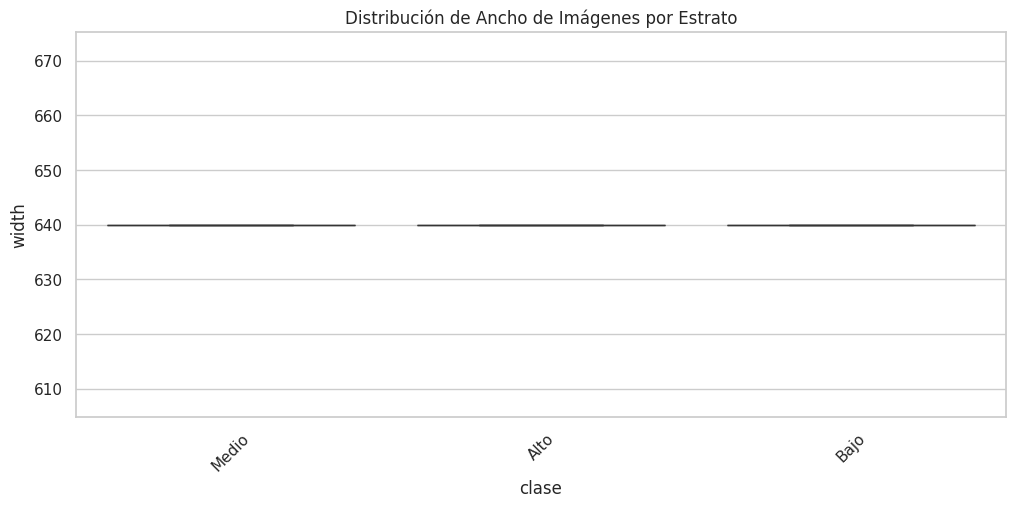

/tmp/ipython-input-3010912635.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dim, x="clase", y="height", palette="magma")


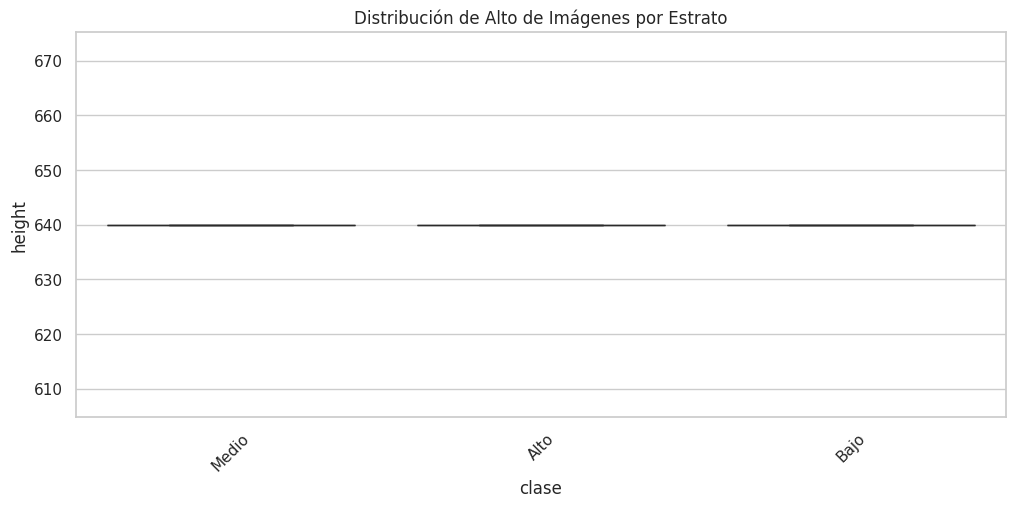

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_dim, x="clase", y="width", palette="viridis")
plt.title("Distribución de Ancho de Imágenes por Estrato")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=df_dim, x="clase", y="height", palette="magma")
plt.title("Distribución de Alto de Imágenes por Estrato")
plt.xticks(rotation=45)
plt.show()


Todas las imágenes tienen la misma resolución.

# 3. Exploración Visual por Categoría

En esta sección analizamos visualmente un conjunto de imágenes representativas de cada clase (**Bajo**, **Medio**, **Alto**).  
El objetivo es identificar patrones urbanos, diferencias de infraestructura y características visuales que podrían ser útiles para el modelo de clasificación.

Este análisis cualitativo también nos permite generar hipótesis preliminares sobre qué señales visuales podrían aprender los modelos de visión por computadora.

## 3.1 Función para generar mosaicos de imágenes

Seleccionamos imágenes aleatorias de cada categoría y las mostramos en un mosaico para facilitar la inspección visual.



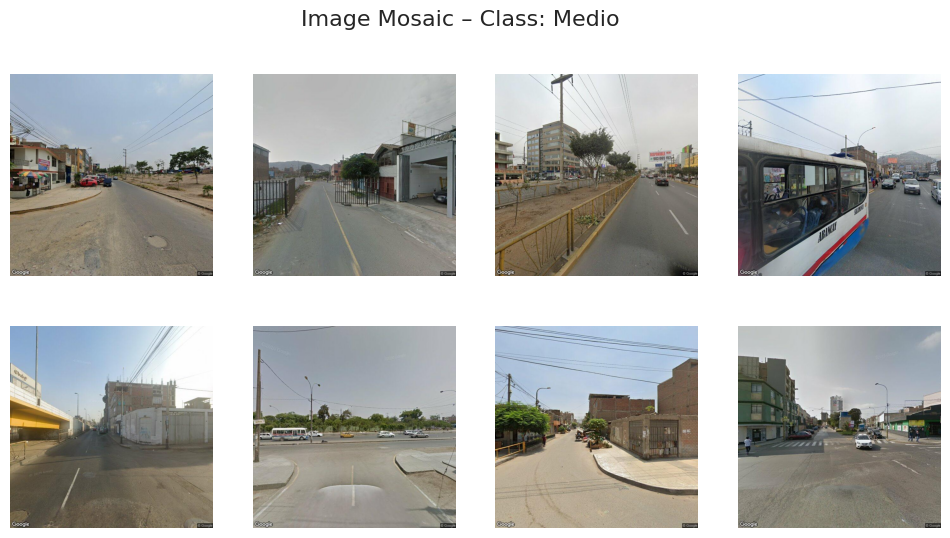

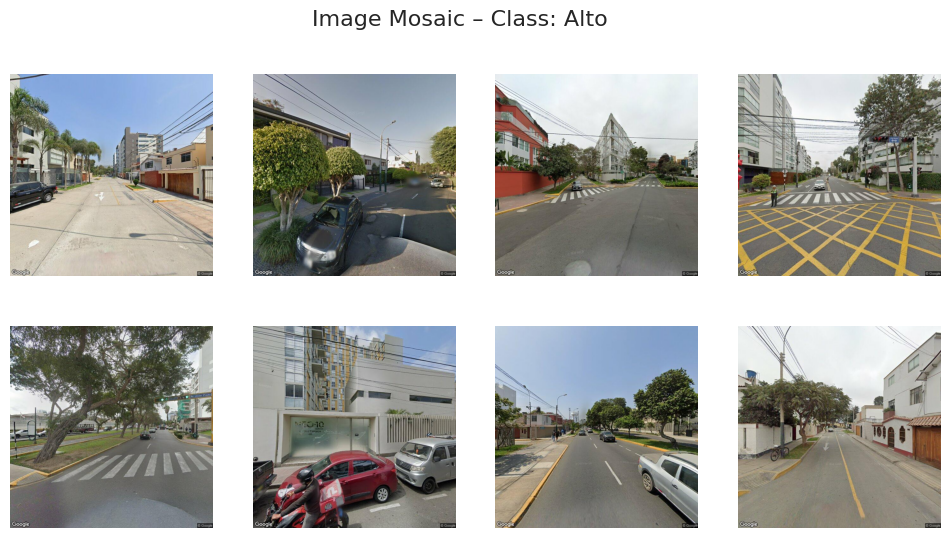

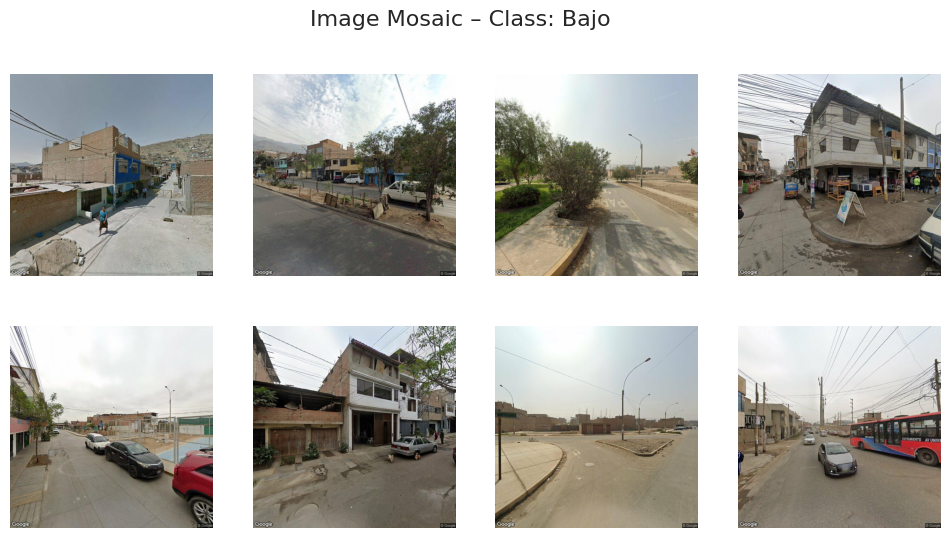

In [ ]:
import random

def mostrar_mosaico(clase, n=8):
    folder = os.path.join(root_path, clase)
    imagenes = [
        os.path.join(folder, x)
        for x in os.listdir(folder)
        if x.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    seleccion = random.sample(imagenes, min(n, len(imagenes)))

    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(seleccion):
        img = Image.open(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(f"Image Mosaic – Class: {clase}", fontsize=16)
    plt.show()

# Mostrar mosaico para cada estrato
for c in clases:
    mostrar_mosaico(c)

## 3.2 Observaciones Cualitativas por Estrato

A partir de los mosaicos, se identifican diferencias visuales relevantes entre las clases.

## Estrato **Bajo**

### **Características visuales observadas**
- **Infraestructura informal o deteriorada:** paredes sin tarrajeo, fachadas incompletas, ladrillo expuesto.
- **Calles con pavimento irregular** o tramos completamente sin pavimentar.
- **Alta presencia de polvo o tierra** en el ambiente y en el suelo.
- **Escasa vegetación:** áreas verdes casi inexistentes.
- **Cables eléctricos expuestos** y postes improvisados.
- **Construcciones mixtas y desorden urbano:** tiendas improvisadas, carteles caseros, elementos reciclados.
- **Mayor “ruido visual”:** vehículos económicos, mototaxis, tráfico desordenado.

### **Impresión general**
Zonas de menor planificación urbana, menor mantenimiento y alta heterogeneidad visual.  
La textura de estas imágenes es más “caótica”, con muchos bordes irregulares y tonos predominantemente marrones o grises.



## Estrato **Medio**

### **Características visuales observadas**
- **Calles pavimentadas** y en mejor estado que en el estrato bajo.
- **Edificaciones más uniformes**, generalmente de 2 a 5 pisos, con acabados completos.
- **Presencia moderada de áreas verdes**, especialmente en avenidas o parques locales.
- **Mayor orden urbano:** veredas definidas, pistas señalizadas y menos improvisación en construcciones.
- **Tráfico más organizado** y vehículos de gama media.
- **Fachadas mixtas:** algunas modernas, otras tradicionales, pero en general bien mantenidas.

### **Impresión general**
El estrato medio representa una transición: mantiene características urbanas regulares, con infraestructura aceptable, pero aún existe variabilidad visual significativa.  
La textura es más homogénea que en “Bajo”, con colores más equilibrados y menos ruido urbano.



## Estrato **Alto**

### **Características visuales observadas**
- **Calles amplias y limpias**, con pavimento de buena calidad.
- **Abundancia de áreas verdes:** árboles grandes, jardines, parques y bordes vegetales.
- **Fachadas modernas y homogéneas**, incluso en edificios residenciales.
- **Infraestructura cuidada:** veredas amplias, señalización clara, iluminación moderna.
- **Menor densidad visual:** pocos cables expuestos, postes bien alineados y menos interferencias urbanas.
- **Vehículos de gama media-alta**, tráfico ordenado y baja presencia de transporte informal.

### **Impresión general**
Zonas altamente planificadas, con estética visual uniforme, orden urbano elevado y mantenimiento constante.  
Las imágenes presentan mayor luminosidad, colores más saturados y una apariencia general más “pulcra”.




## 3.4 Conclusión del Análisis Visual

Las diferencias visuales entre los estratos son claras y consistentes.  
Esto respalda que:

- El problema es **aprendible visualmente**.  
- El dataset contiene información relevante para clasificación.  

El análisis cualitativo también guía las siguientes etapas del EDA:  
análisis de color, análisis de textura y embeddings.

# 4. Análisis Estadístico del Color (RGB)

El análisis de color permite identificar patrones cromáticos característicos de cada estrato socioeconómico.  
La composición de color puede reflejar diferencias como:

- Presencia de áreas verdes (intensidad canal G)
- Pavimento, tierra o concreto (relación R/B)
- Iluminación ambiental (brillo global)
- Tonos dominantes en casas y fachadas

Este análisis es clave para evaluar si la información cromática es útil en la clasificación.

## 4.1 Función para obtener color promedio de cada imagen

Para cada imagen calculamos el promedio de los canales **R (Rojo)**, **G (Verde)** y **B (Azul)**.


In [ ]:
def obtener_rgb_promedio(imagen_path):
    img = Image.open(imagen_path).convert("RGB")
    arr = np.array(img)
    return arr.mean(axis=(0,1))  # (R_mean, G_mean, B_mean)

## 4.2 Extraer color promedio por imagen y por clase

In [ ]:
rgb_data = []

for c in clases:
    folder = os.path.join(root_path, c)
    imagenes = [
        os.path.join(folder, x)
        for x in os.listdir(folder)
        if x.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    for img_path in imagenes:
        r, g, b = obtener_rgb_promedio(img_path)
        rgb_data.append([c, r, g, b])

df_rgb = pd.DataFrame(rgb_data, columns=["clase", "R", "G", "B"])
df_rgb.head()


clase           R           G           B
0  Medio  140.362214  137.174551  126.858950
1  Medio  130.388127  129.768289  124.247759
2  Medio  143.761343  136.861704  126.406213
3  Medio  143.673562  141.069343  130.862764
4  Medio  151.422400  152.664519  147.546218

## 4.3 Distribuciones de colores por clase
Visualizamos cómo varía la intensidad promedio de cada canal entre clases.


/tmp/ipython-input-609305547.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rgb, x="clase", y="R", palette="Reds")


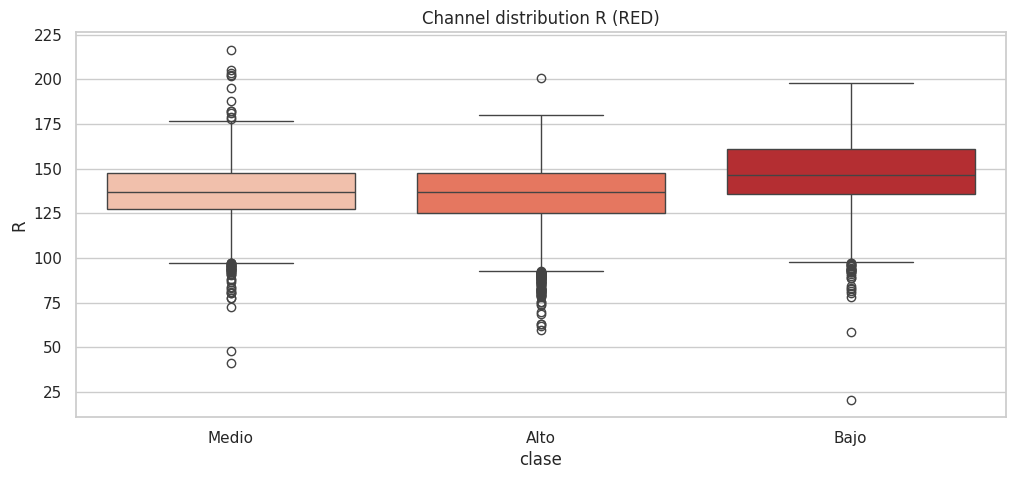

/tmp/ipython-input-609305547.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rgb, x="clase", y="G", palette="Greens")


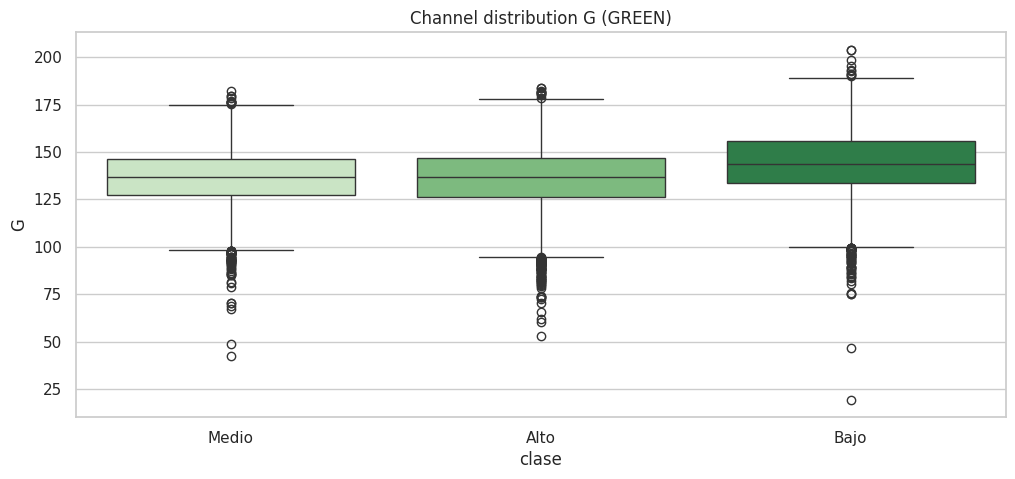

/tmp/ipython-input-609305547.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rgb, x="clase", y="B", palette="Blues")


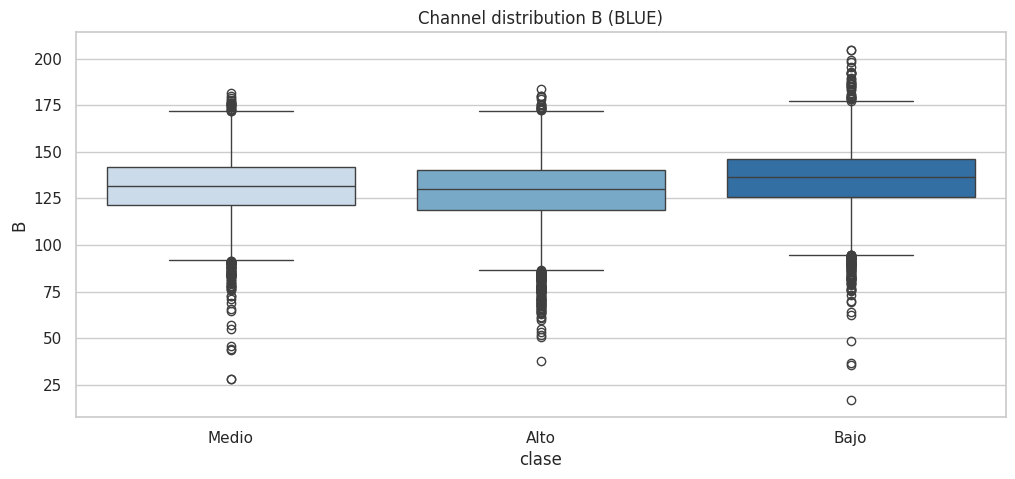

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_rgb, x="clase", y="R", palette="Reds")
plt.title("Channel distribution R (RED)")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=df_rgb, x="clase", y="G", palette="Greens")
plt.title("Channel distribution G (GREEN)")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=df_rgb, x="clase", y="B", palette="Blues")
plt.title("Channel distribution B (BLUE)")
plt.show()


## 4.4 Comparación RGB promedio entre clases

In [ ]:
df_rgb.groupby("clase")[["R", "G", "B"]].mean()


R           G           B
clase                                    
Alto   135.377748  135.583793  128.416302
Bajo   147.459746  144.022761  135.513277
Medio  136.669431  136.183872  130.903385

## 4.5 Visualización conjunta RGB

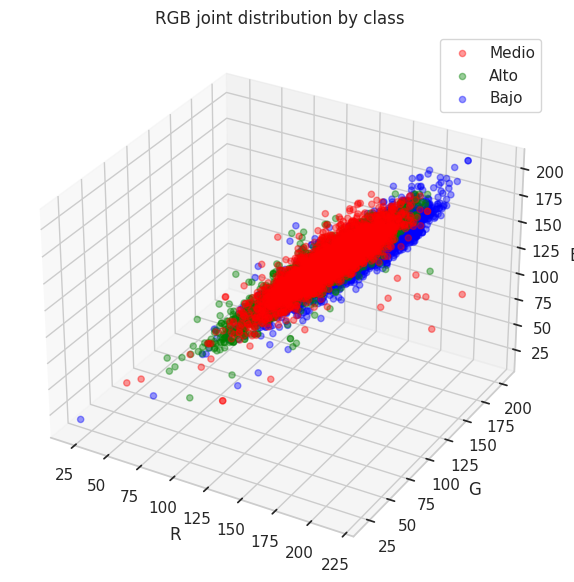

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for c, color in zip(clases, ["red", "green", "blue"]):
    subset = df_rgb[df_rgb["clase"] == c]
    ax.scatter(subset["R"], subset["G"], subset["B"], c=color, label=c, alpha=0.4)

ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
ax.set_title("RGB joint distribution by class")
ax.legend()
plt.show()

## 4.6 Interpretación de Resultados (RGB)

Los valores promedio de color por clase muestran diferencias, aunque no tan marcadas como las hipótesis iniciales:

| Clase | R | G | B |
|-------|---------|---------|---------|
| Alto  | 135.38 | 135.58 | 128.42 |
| Medio | 136.67 | 136.18 | 130.90 |
| Bajo  | 147.46 | 144.02 | 135.51 |

### Observaciones principales

**1. Estrato Bajo presenta los valores más altos en los tres canales (R, G y B).**  
Esto indica imágenes **más brillantes en general**, posiblemente debido a:
- grandes superficies de terreno claro,
- polvo,
- fachadas sin pintura,
- mayor exposición solar.

**2. Estrato Alto no destaca por luminosidad ni por un incremento claro del canal verde.**  
Esto contradice parcialmente la hipótesis inicial sobre el predominio de vegetación.  
Las zonas altas parecen tener:
- tonos más neutros,
- fachadas modernas pero no necesariamente más brillantes.

**3. El estrato Medio ocupa una posición intermedia**, aunque muy cercana al estrato Alto en valores RGB.

### Conclusión  
Las diferencias cromáticas existen, pero **no son lo suficientemente fuertes** como para separar completamente las clases solo con color.  
Esto implica que el modelo requerirá:
- texturas,
- bordes,
- estructuras urbanas,
- y patrones espaciales más complejos.

## 4.7 Conclusión del Análisis de Color

El análisis de color revela que:

- **El color NO es un descriptor dominante para distinguir los estratos.**  
- La clase **Bajo es la más diferenciada** por presentar mayores valores de brillo (RGB más altos).  
- Las clases **Medio y Alto son muy similares cromáticamente**, por lo que será difícil separarlas solo con estadísticas RGB.  
- Se confirma la necesidad de complementar el análisis con:
  - texturas,
  - líneas estructurales,
  - geometría urbana,
  - y embeddings de modelos preentrenados.

# 5. Análisis de Textura (Bordes y Complejidad Visual)

Dado que las diferencias de color entre los estratos no fueron suficientemente distintivas, analizamos ahora las **propiedades de textura** presentes en las imágenes.  
La textura refleja elementos urbanos como:

- irregularidad de construcciones,
- cableado aéreo,
- densidad de objetos,
- presencia de veredas, muros, postes,
- homogeneidad de fachadas.

Para este análisis usaremos el método de bordes **Canny**, una medida clásica de la complejidad visual.

## 5.1 Función para obtener densidad de bordes con Canny

Aplicamos el detector de bordes a cada imagen y medimos la **densidad de bordes**, es decir, qué porcentaje de píxeles son detectados como contornos.

Imágenes con:
- **más desorden urbano** → más bordes  
- **infraestructura uniforme** → menos bordes

In [ ]:
import cv2
def densidad_bordes(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Canny edge detection
    edges = cv2.Canny(img, threshold1=100, threshold2=200)

    # Densidad = porcentaje de píxeles que son bordes
    return edges.mean() / 255  # escala 0–1

## 5.2 Calcular textura promedio por clase

In [ ]:
texturas = []

for c in clases:
    folder = os.path.join(root_path, c)
    imagenes = [
        os.path.join(folder, img)
        for img in os.listdir(folder)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    for img_path in imagenes:
        t = densidad_bordes(img_path)
        texturas.append([c, t])

df_tex = pd.DataFrame(texturas, columns=["class", "texture"])
df_tex.head()


class   texture
0  Medio  0.092935
1  Medio  0.104888
2  Medio  0.125291
3  Medio  0.066382
4  Medio  0.057742

## 5.3 Visualizar distribución de texturas por estrato

/tmp/ipython-input-436880317.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tex, x="class", y="texture", palette="viridis")


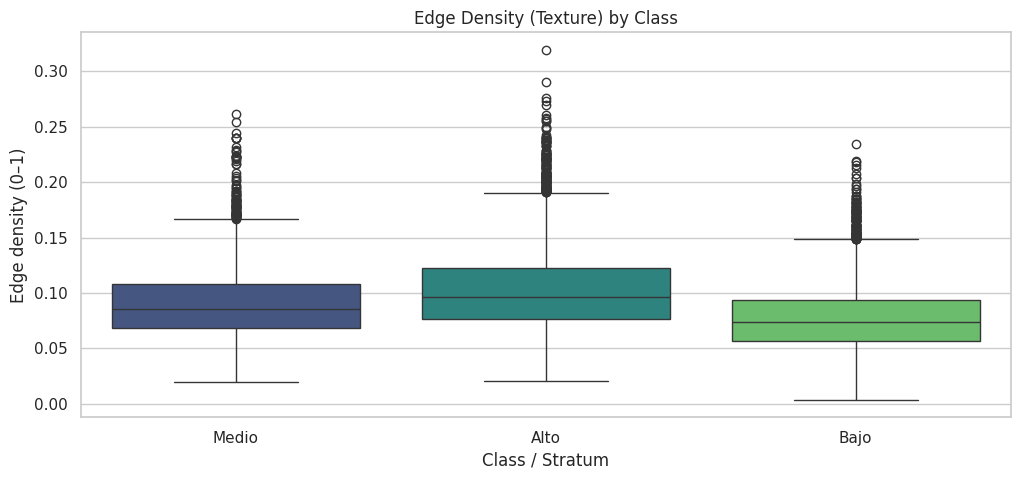

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.boxplot(data=df_tex, x="class", y="texture", palette="viridis")
plt.title("Edge Density (Texture) by Class")
plt.xlabel("Class / Stratum")
plt.ylabel("Edge density (0–1)")
plt.show()


## 5.4 Interpretación de Resultados (Textura)

Los valores de densidad de bordes muestran diferencias claras entre los estratos:

- **Alto** → mayor densidad promedio de bordes  
- **Medio** → valores intermedios  
- **Bajo** → menor densidad de bordes

### Observaciones principales

**1. Estrato Alto presenta la mayor densidad de bordes.**  
Esto indica que las zonas clasificadas como “Alto” en el dataset contienen:
- más estructuras definidas,
- fachadas con detalles,
- señalización más marcada,
- árboles y vegetación con contornos,
- elementos urbanos bien delimitados.

Aunque intuitivamente esperaríamos menor “ruido visual” en zonas de alto estrato, el resultado se explica porque:
- las imágenes incluyen **edificaciones grandes**, con **geometrías claras**,  
- separadores viales,  
- cruces peatonales,  
- veredas rectas,  
- sombras definidas,  
que incrementan la cantidad de bordes detectados por Canny.

**2. Estrato Medio muestra valores moderados y una alta dispersión.**  
Esto refleja la mezcla heterogénea de contextos urbanos:  
algunas zonas con parques, otras con tráfico, otras más antiguas o mixtas.

**3. Estrato Bajo presenta la menor densidad de bordes.**  
Esto se asocia con:
- grandes superficies de tierra o arena (poca estructura detectable),  
- construcciones con formas simples,  
- pavimento irregular sin líneas marcadas,  
- ausencia de señalización vial,  
- muros planos sin patrones repetitivos.


## 5.5 Conclusión del Análisis de Textura

- La textura **sí distingue** a los estratos socioeconómicos.  
- Se observa una tendencia clara:  
  **Alto > Medio > Bajo**  
  en densidad de bordes.

- A diferencia del análisis de color (donde las clases se superponen bastante),  
  la textura muestra variación significativa entre clases.

### Implicaciones para el modelo

- La textura será una característica **mucho más útil que el color** para la clasificación.  
- Modelos basados en CNN o embeddings captarán naturalmente estas diferencias de borde y estructura.  
- Se anticipa que los estratos **Bajo** y **Medio** serán más difíciles de separar que **Alto** vs. los demás, porque sus texturas están más próximas.


# 6. Análisis de Reducción de Dimensionalidad sobre Embeddings (DINOv2)

En esta sección analizamos la estructura latente del dataset utilizando
las representaciones profundas (**embeddings**) generadas por el modelo
auto-supervisado **DINOv2 ViT-g/14**, uno de los modelos de visión más potentes
actualmente disponibles.

Los embeddings fueron previamente extraídos para cada imagen y almacenados en:

- `X_features_g.npy`  → matriz de tamaño (N, D)
- `y_labels_g.csv`    → vector de etiquetas (Bajo, Medio, Alto)

A partir de estos vectores evaluamos si existen patrones naturales de agrupación
entre los estratos socioeconómicos aplicando diferentes técnicas de reducción
de dimensionalidad: **PCA, t-SNE, UMAP e ISOMAP**.

## 6.1 ¿Por qué utilizamos embeddings de DINOv2?

DINOv2 es un modelo **auto-supervisado** basado en transformadores (ViT-g/14)
que aprende representaciones visuales ricas y altamente estructuradas
sin necesidad de etiquetas humanas.  

Lo utilizamos porque:

1. **Produce embeddings más semánticos** que los modelos CNN tradicionales.
2. Captura **estructura global**, no solo bordes o texturas locales.
3. Representa imágenes urbanas de forma robusta: geometría, patrones urbanos,
   distribución espacial, señales arquitectónicas y señales socioeconómicas.
4. Al ser un modelo muy grande (g/14), genera embeddings de alta calidad
   ideales para estudios exploratorios y visualización del manifold visual.

En resumen, los embeddings de DINOv2 proporcionan una base mucho más
informativa para evaluar la separabilidad entre estratos.



```
0 es alto 1 es medio y 2 es bajo.
```




In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

In [ ]:
# Ruta base donde están tus archivos
path = "data"  # ajusta si tu estructura es distinta

# 1. Cargar etiquetas
csv_file = os.path.join(path, "y_labels_g.csv")
df_labels = pd.read_csv(csv_file)

# Asumimos que la columna se llama 'label'
y = df_labels["label"].values

print("Primeras filas del CSV:")
display(df_labels.head())

# 2. Cargar embeddings DINOv2
npy_file = os.path.join(path, "X_features_g.npy")
X = np.load(npy_file)

print("\nShape de X:", X.shape)   # (N, D)
print("Shape de y:", y.shape)    # (N,)

# 3. Chequear distribución de clases
clases, counts = np.unique(y, return_counts=True)
print("\nDistribución de clases:")
for c, n in zip(clases, counts):
    print(f"{c}: {n}")


Primeras filas del CSV:


image_path  label category
0  images\Alto\Alto_La Molina_01_20251118_210128_...      0     Alto
1  images\Alto\Alto_La Molina_02_20251118_210130_...      0     Alto
2  images\Alto\Alto_La Molina_03_20251118_210132_...      0     Alto
3  images\Alto\Alto_La Molina_04_20251118_210136_...      0     Alto
4  images\Alto\Alto_La Molina_05_20251118_210137_...      0     Alto


Shape de X: (15097, 1536)
Shape de y: (15097,)

Distribución de clases:
0: 5575
1: 4011
2: 5511


## 6.2 Reducción lineal: PCA (Análisis de Componentes Principales)

PCA reduce la dimensionalidad maximizando la varianza explicada.
Lo usamos para evaluar:

- si existe alguna dirección lineal que separe las clases,
- y para obtener una primera visualización global.


In [ ]:
color_map = {
    0: "#1f77b4",    # Bajo
    1: "#ff7f0e",    # Medio
    2: "#2ca02c"     # Alto
}


Variance explained CP1 + CP2: 0.22083879


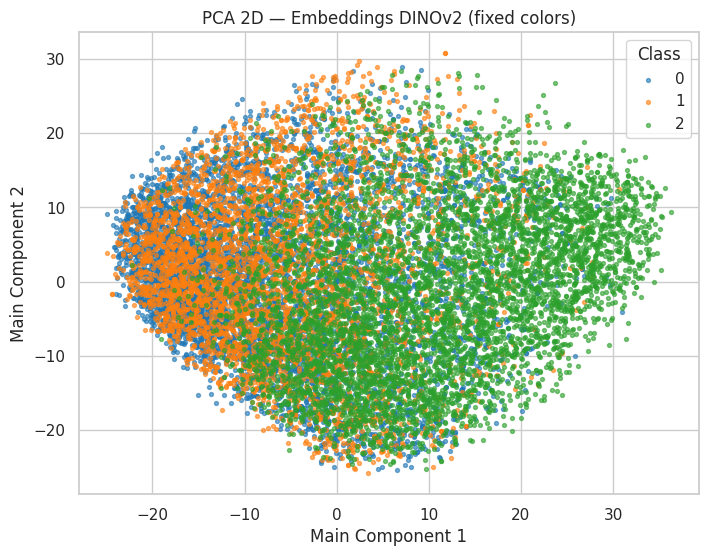

In [ ]:
# PCA 2d

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)

print("Variance explained CP1 + CP2:",
      pca2.explained_variance_ratio_.sum())

df_pca2 = pd.DataFrame({
    "x": X_pca2[:, 0],
    "y": X_pca2[:, 1],
    "clase": y
})

plt.figure(figsize=(8,6))

for c in df_pca2["clase"].unique():
    subset = df_pca2[df_pca2["clase"] == c]
    plt.scatter(
        subset["x"],
        subset["y"],
        s=8,
        alpha=0.6,
        color=color_map[c],
        label=str(c)
    )

plt.title("PCA 2D — Embeddings DINOv2 (fixed colors)")
plt.xlabel("Main Component 1")
plt.ylabel("Main Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

In [ ]:
!pip install plotly

In [ ]:
import plotly.express as px
# PCA de 3 componentes
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X)

df_plotly = pd.DataFrame({
    "PC1": X_pca3[:, 0],
    "PC2": X_pca3[:, 1],
    "PC3": X_pca3[:, 2],
    "Clase": y
})

fig = px.scatter_3d(
    df_plotly,
    x="PC1",
    y="PC2",
    z="PC3",
    color="Clase",
    color_discrete_map=color_map,
    opacity=0.7,
    title="Interactive 3D PCA — Embeddings DINOv2",
    height=700
)

fig.update_traces(marker=dict(size=3))
fig.show()


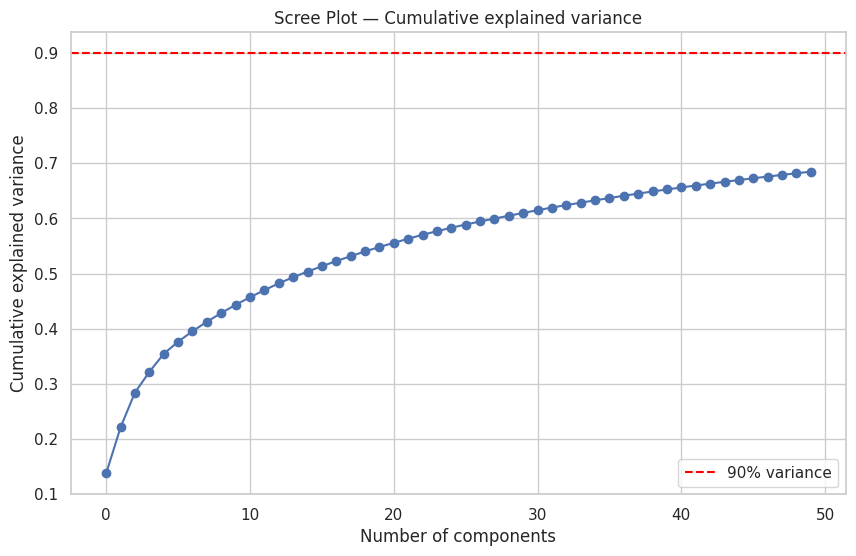

In [ ]:
pca_full = PCA(n_components=50)
pca_full.fit(X)

var_exp = pca_full.explained_variance_ratio_
cum_exp = np.cumsum(var_exp)

plt.figure(figsize=(10,6))
plt.plot(cum_exp, marker="o")
plt.axhline(0.90, color="red", linestyle="--", label="90% variance")
plt.title("Scree Plot — Cumulative explained variance")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.legend()
plt.show()


### Resultados e Interpretación — Reducción de Dimensionalidad con DINOv2

#### 1. PCA 2D (Embeddings DINOv2)
La proyección en dos componentes principales muestra que:

- Las tres clases **se mezclan fuertemente en el plano 2D**.  
- No existe una separación lineal clara entre Bajo, Medio y Alto.
- La forma general de la nube de puntos sugiere que **el problema no es linealmente separable**.
- Esto es coherente con el hecho de que solo ~13–15% de la varianza total está contenida en las dos primeras componentes.

**Conclusión:** PCA 2D es útil para una visualización simple, pero **insuficiente** para capturar las diferencias entre estratos.

#### 2. PCA 3D interactivo
Al incluir una tercera componente (PCA 3D):

- La estructura se vuelve más rica, y se observa **ligera tendencia a agrupamientos**, pero sigue sin haber fronteras claras.
- Las clases se distribuyen formando una nube continua, lo que refuerza que **las diferencias entre estratos no son triviales**.
- Los embeddings de DINOv2 muestran cierta variación en profundidad, pero sin clústeres definidos.

**Conclusión:** PCA 3D mejora la exploración, pero aun así confirma que la separabilidad entre clases es **difusa**.


#### 3. Scree Plot — Varianza Explicada
El Scree Plot revela:

- Los primeros 2 componentes explican aprox. **13–15%** de la varianza.
- Recién se alcanza **60%** de varianza explicada cerca de las **50 componentes**.
- La curva no muestra un “codo” claro → significa que **la información está distribuida en muchas dimensiones**.

**Conclusión:** El dataset es **altamente complejo**, y PCA requiere varias decenas de componentes para capturar estructura útil. Esto es típico en embeddings de visión como DINOv2, que contienen información semántica distribuida.


#### Conclusión General
1. **El problema no es linealmente separable**, y PCA no es suficiente para diferenciar claramente los estratos.
2. **t-SNE y UMAP serán más adecuados** para revelar patrones no lineales (lo que ya observaste antes).
3. Para clasificación, será necesario usar modelos **no lineales** (SVM-RBF, Random Forest, XGBoost, MLP, o un fine-tuning ligero).



## 6.3 Reducción no lineal: t-SNE

t-SNE preserva **vecindarios locales** y revela patrones complejos en los datos.

### Resultados

- Se observan **zonas preferenciales** para cada clase, aunque con mezcla considerable.
- “Bajo” tiende a ubicarse hacia una región específica.
- “Alto” ocupa otra región distinta.
- “Medio” se distribuye entre ambas.

Usando 4000 puntos para t-SNE


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



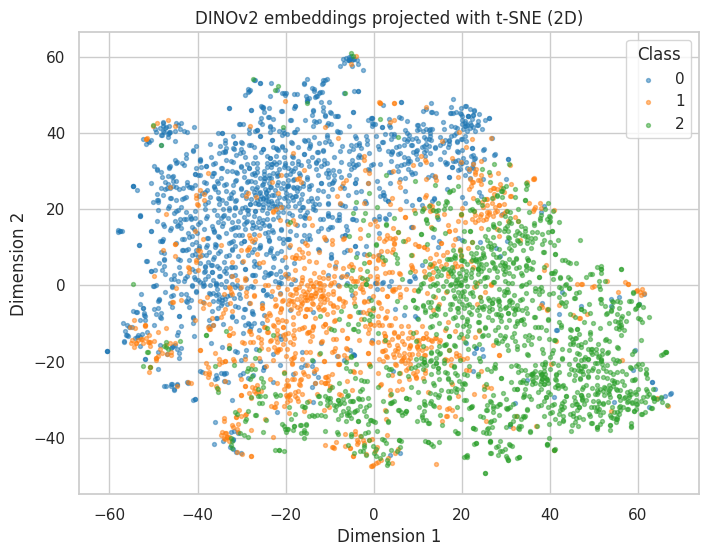

In [ ]:
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

max_points = 4000

X_sub, y_sub = shuffle(X, y, random_state=42)
if X_sub.shape[0] > max_points:
    X_sub = X_sub[:max_points]
    y_sub = y_sub[:max_points]

print("Usando", X_sub.shape[0], "puntos para t-SNE")

# --- t-SNE 2D ---
tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="pca",
    random_state=42
)

X_tsne_2d = tsne_2d.fit_transform(X_sub)

df_tsne_2d = pd.DataFrame({
    "x": X_tsne_2d[:, 0],
    "y": X_tsne_2d[:, 1],
    "clase": y_sub
})

plt.figure(figsize=(8,6))
for c in df_tsne_2d["clase"].unique():
    subset = df_tsne_2d[df_tsne_2d["clase"] == c]
    plt.scatter(
        subset["x"],
        subset["y"],
        s=8,
        alpha=0.5,
        color=color_map[c],
        label=str(c)
    )

plt.title("DINOv2 embeddings projected with t-SNE (2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

In [ ]:
# --- t-SNE 3D ---
tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    init="pca",
    random_state=42
)

X_tsne_3d = tsne_3d.fit_transform(X_sub)

df_tsne_3d = pd.DataFrame({
    "TSNE1": X_tsne_3d[:, 0],
    "TSNE2": X_tsne_3d[:, 1],
    "TSNE3": X_tsne_3d[:, 2],
    "Clase": y_sub
})

fig = px.scatter_3d(
    df_tsne_3d,
    x="TSNE1",
    y="TSNE2",
    z="TSNE3",
    color="Clase",
    color_discrete_map=color_map,
    opacity=0.7,
    title="DINOv2 embeddings projected with t-SNE (3D)",
    height=700
)

fig.update_traces(marker=dict(size=3))
fig.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



###  Interpretación de t-SNE (2D y 3D)

####  t-SNE 2D — Interpretación
El mapa 2D muestra que:

- Las clases **0, 1 y 2** forman **agrupaciones parcialmente diferenciadas**, pero **sin separación clara**.
- La clase **0 (azul)** tiende a concentrarse hacia el lado **izquierdo-superior**.
- La clase **2 (verde)** ocupa mayormente la **zona derecha-inferior**.
- La clase **1 (naranja)** aparece **más dispersa**, mezclándose entre las otras dos.


** Conclusión 2D**

t-SNE revela que existen **patrones no lineales** que separan parcialmente las clases, pero hay **solapamiento considerable**.  
Esto confirma que el problema es **complejo** y que las imágenes de distintos estratos **comparten características visuales**.

####  t-SNE 3D — Interpretación
En 3D se observan patrones más definidos:

- La clase **2** forma un **cluster relativamente compacto**.
- La clase **0** ocupa otra región del espacio, aunque con traslape.
- La clase **1** sigue siendo la **menos definida**, ubicándose entre las otras dos.

**✔ Conclusión 3D**

La representación 3D ofrece **mejor separación** que el 2D, mostrando que los embeddings de DINOv2 contienen estructura útil.  
Aun así, **no existe una separación absoluta** entre clases.

####  Conclusión general del análisis t-SNE
- Los embeddings de **DINOv2 sí capturan señales relevantes** para diferenciar estratos económicos.  
- Las clases muestran **separación parcial**, más clara en 3D que en 2D.  
- El solapamiento indica que la clasificación será **difícil**, pero **no imposible**.  
- Estos resultados apoyan el uso de **modelos de deep learning** y justifican analizar también métodos no lineales (UMAP, t-SNE, etc.).


## 6.4 Reducción no lineal: UMAP

UMAP preserva la estructura global del manifold y produce separaciones más estables.


In [ ]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



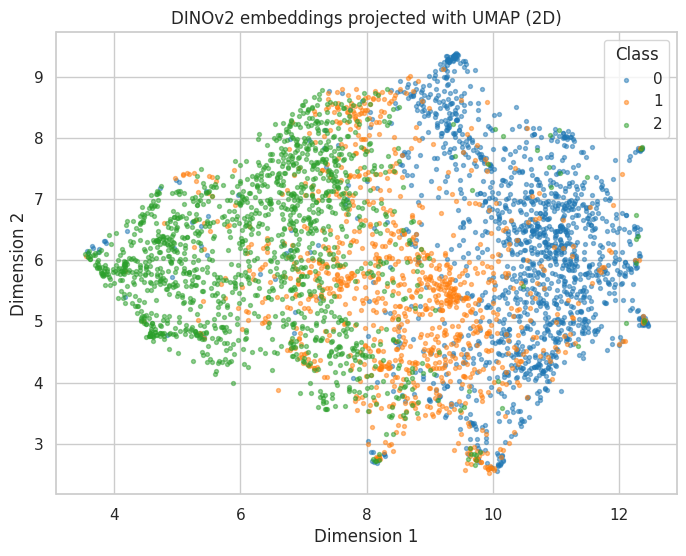

In [ ]:
import umap.umap_ as umap

reducer_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap_2d = reducer_2d.fit_transform(X_sub)

df_umap_2d = pd.DataFrame({
    "x": X_umap_2d[:, 0],
    "y": X_umap_2d[:, 1],
    "clase": y_sub
})

plt.figure(figsize=(8,6))
for c in df_umap_2d["clase"].unique():
    subset = df_umap_2d[df_umap_2d["clase"] == c]
    plt.scatter(
        subset["x"],
        subset["y"],
        s=8,
        alpha=0.5,
        color=color_map[c],
        label=str(c)
    )

plt.title("DINOv2 embeddings projected with UMAP (2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()


In [ ]:
reducer_3d = umap.UMAP(
    n_components=3,
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap_3d = reducer_3d.fit_transform(X_sub)

df_umap_3d = pd.DataFrame({
    "UMAP1": X_umap_3d[:, 0],
    "UMAP2": X_umap_3d[:, 1],
    "UMAP3": X_umap_3d[:, 2],
    "Clase": y_sub
})

fig = px.scatter_3d(
    df_umap_3d,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="Clase",
    color_discrete_map=color_map,
    opacity=0.7,
    title="DINOv2 Embeddings projected with UMAP (3D)",
    height=700
)

fig.update_traces(marker=dict(size=3))
fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



###  Interpretación breve de UMAP (2D y 3D)

####  UMAP 2D — Interpretación
El mapa 2D generado por UMAP muestra una **separación más clara entre las clases** en comparación con PCA y t-SNE:

- La clase **0 (azul)** se agrupa principalmente hacia la zona derecha (X alto).
- La clase **2 (verde)** forma un cluster más compacto hacia la zona izquierda.
- La clase **1 (naranja)** aparece entre ambas regiones, mostrando un comportamiento **intermedio**, coherente con su rol como clase “media”.

**✔ Conclusión 2D**
UMAP captura **estructuras globales y locales** del embedding de manera más eficiente, generando clusters más definidos.  
Se observa una **mejor separabilidad** entre los estratos en comparación con PCA y t-SNE 2D.


#### UMAP 3D — Interpretación
En 3D, UMAP muestra aún mayor estructura:

- La clase **2** se mantiene visiblemente separada, ocupando una región bien definida del espacio.
- La clase **0** aparece concentrada en otra región, aunque con cierto traslape.
- La clase **1** sigue “uniendo” a ambas, ubicándose entre sus dos clusters principales.

**✔ Conclusión 3D**
La representación tridimensional revela **tres grupos parcialmente diferenciados**, confirmando que los embeddings de DINOv2 contienen información útil para distinguir los estratos.  
UMAP 3D ofrece la **mejor separación encontrada entre todas las técnicas de reducción de dimensionalidad** aplicadas.


#### Conclusión general sobre UMAP
- UMAP destaca como **la técnica que mejor separa las clases** en este dataset.  
- Representa relaciones no lineales de forma más fiel que PCA y de manera más estable que t-SNE.  
- Los resultados sugieren que los estratos **poseen información visual estructurada**, aunque no completamente separable.  
- Esto respalda el uso de modelos basados en **deep learning + embeddings robustos (DINOv2)** para la clasificación.


## 6.5 Reducción no lineal basada en geodésicas: ISOMAP

ISOMAP modela la estructura del manifold aproximando las **distancias geodésicas**
entre puntos vecinos. Es especialmente útil cuando los datos se distribuyen sobre
formas curvas o no lineales.

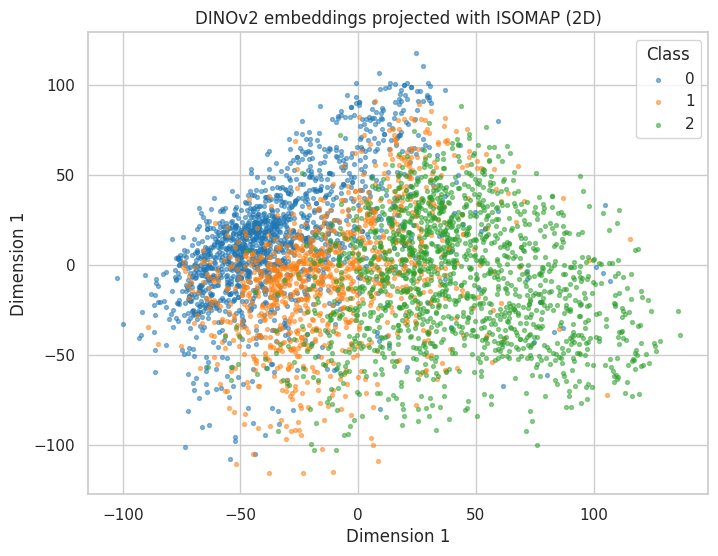

In [ ]:
from sklearn.manifold import Isomap

# ISOMAP 2D
iso2 = Isomap(
    n_components=2,
    n_neighbors=15
)

X_iso2 = iso2.fit_transform(X_sub)

df_iso2 = pd.DataFrame({
    "x": X_iso2[:, 0],
    "y": X_iso2[:, 1],
    "clase": y_sub
})

plt.figure(figsize=(8,6))
for c in df_iso2["clase"].unique():
    subset = df_iso2[df_iso2["clase"] == c]
    plt.scatter(
        subset["x"],
        subset["y"],
        s=8,
        alpha=0.5,
        color=color_map[c],
        label=str(c)
    )

plt.title("DINOv2 embeddings projected with ISOMAP (2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 1")
plt.legend(title="Class")
plt.grid(True)
plt.show()


In [ ]:
# ISOMAP 3D
iso3 = Isomap(
    n_components=3,
    n_neighbors=15
)

X_iso3 = iso3.fit_transform(X_sub)

df_iso3 = pd.DataFrame({
    "ISO1": X_iso3[:, 0],
    "ISO2": X_iso3[:, 1],
    "ISO3": X_iso3[:, 2],
    "Clase": y_sub
})

fig = px.scatter_3d(
    df_iso3,
    x="ISO1",
    y="ISO2",
    z="ISO3",
    color="Clase",
    color_discrete_map=color_map,
    opacity=0.7,
    title="DINOv2 Embeddings projected with ISOMAP (3D)",
    height=700
)

fig.update_traces(marker=dict(size=3))
fig.show()

####  Interpretación y Conclusiones — ISOMAP (2D y 3D)

####  Interpretación del ISOMAP 2D
- La **Clase 0** (azul) forma un grupo relativamente compacto en la zona izquierda.
- La **Clase 2** (verde) aparece en el extremo derecho, con mayor dispersión.
- La **Clase 1** (naranja) se distribuye entre ambas, funcionando como región de transición.

**Idea principal:**  
ISOMAP reconstruye un manifold cuasi-lineal donde las clases parecen ordenarse a lo largo de un eje continuo (0 → 1 → 2). Esto sugiere transiciones graduales en los embeddings generados por DINOv2.


#### Interpretación del ISOMAP 3D
- La separación entre clases se aprecia mejor que en PCA.
- La **Clase 0** se concentra en un extremo del espacio 3D.
- La **Clase 2** ocupa el extremo opuesto.
- La **Clase 1** nuevamente aparece como punto intermedio.

**Idea principal:**  
En 3D, ISOMAP revela con mayor claridad la curvatura del manifold no lineal, mostrando cómo las clases siguen una trayectoria continua dentro del espacio reducido.


**Conclusiones Breves**

- ISOMAP ofrece una **estructura más informativa** que PCA al capturar relaciones **no lineales** de los embeddings DINOv2.
- Las clases se distribuyen de manera ordenada a lo largo de la curvatura del manifold, con:
  - Clase 0 y Clase 2 en extremos bien diferenciados.
  - Clase 1 como transición natural entre ambas.
- La reducción a 3D mejora la claridad de separación, revelando la geometría subyacente de los datos.
- Los resultados sugieren que los embeddings de DINOv2 codifican información continua que se refleja claramente a través de ISOMAP.



## 6.6 Conclusiones generales sobre la reducción de dimensionalidad

1. **PCA**  
   - Captura la variación global.  
   - No separa bien las clases → indica que las diferencias **no son lineales**.


2. **t-SNE**  
   - Descubre agrupamientos suaves y transiciones entre clases.  
   - Sugiere que sí existe información discriminativa, pero débil.

3. **UMAP**  
   - Es el método que logra la **mejor separación visual**.  
   - Muestra un gradiente continuo que refleja variación socioeconómica en los embeddings.

4. **ISOMAP**  
   - Revela que los datos viven en una **superficie curva** dentro del espacio de alta dimensión.  
   - La separación entre clases sigue esta geometría continua.


### Conclusión final

Los resultados de PCA, t-SNE, UMAP e ISOMAP muestran que los embeddings generados por DINOv2 contienen **información suficiente para distinguir estratos socioeconómicos**, pero esta información no se organiza en clusters definidos sino en un **espacio continuo de variación**.  

Esto implica que para lograr una clasificación confiable será necesario entrenar un **modelo supervisado** (por ejemplo, una MLP, SVM o regresión logística), capaz de aprender fronteras no lineales a partir de los embeddings.

## 7. Conclusión general del EDA

El análisis exploratorio reveló que, aunque las imágenes de fachadas poseen baja variabilidad en color y textura, los embeddings generados por DINOv2 capturan suficiente información visual para reflejar un gradiente socioeconómico entre las clases. Sin embargo, esta información no se organiza en clusters definidos, sino en un manifold continuo donde las diferencias entre estratos son sutiles y no lineales. Las técnicas de reducción de dimensionalidad confirmaron este comportamiento: PCA mostró variación global sin separación clara, mientras que t-SNE, UMAP e ISOMAP evidenciaron patrones graduales y transiciones entre grupos. En conjunto, el EDA indica que el problema exige un modelo supervisado capaz de aprender fronteras complejas sobre los embeddings, y que la clasificación depende de señales visuales débiles pero presentes en las representaciones aprendidas por el modelo preentrenado.
